### 冷启动问题

在上个 notebook 中，你第一次听说了**冷启动问题**。如果遇到新用户或新电影，协同过滤方法将无法做出预测。

你需要使用在上节课学习的技巧做出预测，例如针对新项目使用基于内容的推荐方法，或针对新用户使用基于排名的推荐方法。  

在创建推荐系统的最后一步，我们将处理这些极端情形。首先请运行以下单元格。

### 矩阵分解 - 适合协同过滤的情形

运行以下单元格后会获得以下信息：

`1.` **reviews** - 一个评价 dataframe

`2.` **movies** - 一个电影 dataframe

`3.` **create_train_test** - 一个创建训练数据集和验证数据集的函数

`4.` **predict_rating** - 一个参数包括用户和电影的函数，并且能够使用 FunkSVD 提供预测

`5.` **train_df** 和 **val_df** - 在上个 notebook 中使用的训练集和测试集

`6.` **user_mat** 和 **movie_mat** - 通过 FunkSVD 获得的 u 和 v 矩阵

`7.` **train_data_df** - 包含评分的用户-电影矩阵。对此矩阵执行了 FunkSVD

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pickle

# Read in the datasets
movies = pd.read_csv('movies_clean.csv')
reviews = pd.read_csv('reviews_clean.csv')

del movies['Unnamed: 0']
del reviews['Unnamed: 0']

def create_train_test(reviews, order_by, training_size, testing_size):
    '''    
    INPUT:
    reviews - (pandas df) dataframe to split into train and test
    order_by - (string) column name to sort by
    training_size - (int) number of rows in training set
    testing_size - (int) number of columns in the test set
    
    OUTPUT:
    training_df -  (pandas df) dataframe of the training set
    validation_df - (pandas df) dataframe of the test set
    '''
    reviews_new = reviews.sort_values(order_by)
    training_df = reviews_new.head(training_size)
    validation_df = reviews_new.iloc[training_size:training_size+testing_size]
    
    return training_df, validation_df

def predict_rating(user_matrix, movie_matrix, user_id, movie_id):
    '''
    INPUT:
    user_matrix - user by latent factor matrix
    movie_matrix - latent factor by movie matrix
    user_id - the user_id from the reviews df
    movie_id - the movie_id according the movies df
    
    OUTPUT:
    pred - the predicted rating for user_id-movie_id according to FunkSVD
    '''
    # Create series of users and movies in the right order
    user_ids_series = np.array(train_data_df.index)
    movie_ids_series = np.array(train_data_df.columns)
    
    # User row and Movie Column
    user_row = np.where(user_ids_series == user_id)[0][0]
    movie_col = np.where(movie_ids_series == movie_id)[0][0]
    
    # Take dot product of that row and column in U and V to make prediction
    pred = np.dot(user_matrix[user_row, :], movie_matrix[:, movie_col])
    
    return pred

# Use our function to create training and test datasets
train_df, val_df = create_train_test(reviews, 'date', 8000, 2000)

# Create user-by-item matrix - this will keep track of order of users and movies in u and v
train_user_item = train_df[['user_id', 'movie_id', 'rating', 'timestamp']]
train_data_df = train_user_item.groupby(['user_id', 'movie_id'])['rating'].max().unstack()
train_data_np = np.array(train_data_df)

# Read in user and movie matrices
user_file = open("user_matrix", 'rb')
user_mat = pickle.load(user_file)
user_file.close()

movie_file = open("movie_matrix", 'rb')
movie_mat = pickle.load(movie_file)
movie_file.close()

### 验证预测值

遗憾的是，你无法对测试集中的每个用户-电影组合做出预测，因为某些用户或电影是新添加的。  

但是，你可以对 user_mat 和 movie_mat 矩阵中存在的用户-电影对进行预测。  

`1.` 请完成以下函数，看看所有预测评分的平均值与实际值相差多少。

In [4]:
def validation_comparison(val_df, user_mat=user_mat, movie_mat=movie_mat):
    '''
    INPUT:
    val_df - the validation dataset created in the third cell above
    user_mat - U matrix in FunkSVD
    movie_mat - V matrix in FunkSVD
        
    OUTPUT:
    rmse - RMSE of how far off each value is from it's predicted value
    perc_rated - percent of predictions out of all possible that could be rated
    actual_v_pred - a 10 x 10 grid with counts for actual vs predicted values
    '''
        
    val_users = np.array(val_df['user_id'])
    val_movies = np.array(val_df['movie_id'])
    val_ratings = np.array(val_df['rating'])
    
    sse = 0
    num_rated = 0
    preds, acts = [], []
    actual_v_pred = np.zeros((10,10))
    for idx in range(len(val_users)):
        try:
            pred = predict_rating(user_mat, movie_mat, val_users[idx], val_movies[idx])
            sse += (val_ratings[idx] - pred)**2
            num_rated+=1
            preds.append(pred)
            acts.append(val_ratings[idx])
            actual_v_pred[11-int(val_ratings[idx]-1), int(round(pred)-1)]+=1
        
        except:
            continue
    
    rmse = np.sqrt(sse/num_rated)
    perc_rated = num_rated/len(val_users)
    return rmse, perc_rated, actual_v_pred, preds, acts

2.04861637989704 0.4795


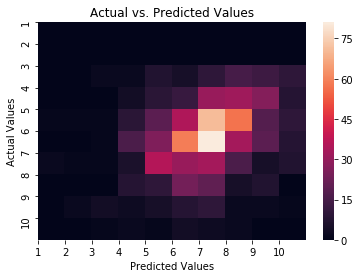

In [5]:
# How well did we do? # Make some plots and calculate some statistics to 
# understand how well this technique is working
rmse, perc_rated, actual_v_pred, preds, acts = validation_comparison(val_df)
print(rmse, perc_rated)
sns.heatmap(actual_v_pred);
plt.xticks(np.arange(10), np.arange(1,11));
plt.yticks(np.arange(10), np.arange(1,11));
plt.xlabel("Predicted Values");
plt.ylabel("Actual Values");
plt.title("Actual vs. Predicted Values");

/Users/francis/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


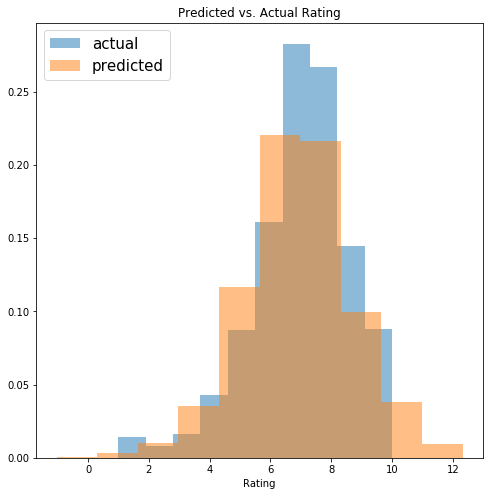

In [6]:
plt.figure(figsize=(8,8))
plt.hist(acts, normed=True, alpha=.5, label='actual');
plt.hist(preds, normed=True, alpha=.5, label='predicted');
plt.legend(loc=2, prop={'size': 15});
plt.xlabel('Rating');
plt.title('Predicted vs. Actual Rating');

`2.` 我们的预测值并没有多糟糕。但是，我们无法对多少个用户-电影对做出预测？请在以下单元格中回答这个问题。

In [7]:
# From the above, this can be calculated as follows:
print("Number not rated {}".format(int(len(val_df['rating'])*(1-perc_rated))))
print("Number rated {}.".format(int(len(val_df['rating'])*perc_rated)))

Number not rated 1041
Number rated 959.


### 对新电影采用基于内容的推荐方法

如果上述流程都没有问题，你将发现我们依然需要处理一些极端情况。我们需要针对这些新用户和电影应用在上节课编写的一些代码。以下代码可以基于内容做出推荐，能够发现与其他电影相似的电影。这部分代码来自上节课的 **5_Content_Based_Recommendations** 部分。

以下函数 **find_similar_movies** 将仅根据内容提供与任何电影相似的电影。  

请运行以下单元格并获取基于内容的相似性函数。

In [8]:
# Subset so movie_content is only using the dummy variables for each genre and the 3 century based year dummy columns
movie_content = np.array(movies.iloc[:,4:])

# Take the dot product to obtain a movie x movie matrix of similarities
dot_prod_movies = movie_content.dot(np.transpose(movie_content))


def find_similar_movies(movie_id):
    '''
    INPUT
    movie_id - a movie_id 
    OUTPUT
    similar_movies - an array of the most similar movies by title
    '''
    # find the row of each movie id
    movie_idx = np.where(movies['movie_id'] == movie_id)[0][0]
    
    # find the most similar movie indices - to start I said they need to be the same for all content
    similar_idxs = np.where(dot_prod_movies[movie_idx] == np.max(dot_prod_movies[movie_idx]))[0]
    
    # pull the movie titles based on the indices
    similar_movies = np.array(movies.iloc[similar_idxs, ]['movie'])
    
    return similar_movies
    
    
def get_movie_names(movie_ids):
    '''
    INPUT
    movie_ids - a list of movie_ids
    OUTPUT
    movies - a list of movie names associated with the movie_ids
    
    '''
    movie_lst = list(movies[movies['movie_id'].isin(movie_ids)]['movie'])
   
    return movie_lst

### 对新用户采用基于排名的推荐方法

通过上述两个代码单元格，我们能够对在用户-电影矩阵的任何部分具有评分的电影-用户对做出推荐。我们还可以通过电影相似性针对从未获得评分的电影预测评分。

在最后一部分，我们需要对新用户做出推荐。我们可以利用在第一节课的 **2_Most_Popular_Recommendations** 部分创建的函数。请运行以下单元格并获取这些函数。

请运行以下单元格并获取基于排名的函数。

In [9]:
def create_ranked_df(movies, reviews):
        '''
        INPUT
        movies - the movies dataframe
        reviews - the reviews dataframe
        
        OUTPUT
        ranked_movies - a dataframe with movies that are sorted by highest avg rating, more reviews, 
                        then time, and must have more than 4 ratings
        '''
        
        # Pull the average ratings and number of ratings for each movie
        movie_ratings = reviews.groupby('movie_id')['rating']
        avg_ratings = movie_ratings.mean()
        num_ratings = movie_ratings.count()
        last_rating = pd.DataFrame(reviews.groupby('movie_id').max()['date'])
        last_rating.columns = ['last_rating']

        # Add Dates
        rating_count_df = pd.DataFrame({'avg_rating': avg_ratings, 'num_ratings': num_ratings})
        rating_count_df = rating_count_df.join(last_rating)

        # merge with the movies dataset
        movie_recs = movies.set_index('movie_id').join(rating_count_df)

        # sort by top avg rating and number of ratings
        ranked_movies = movie_recs.sort_values(['avg_rating', 'num_ratings', 'last_rating'], ascending=False)

        # for edge cases - subset the movie list to those with only 5 or more reviews
        ranked_movies = ranked_movies[ranked_movies['num_ratings'] > 4]
        
        return ranked_movies
    

def popular_recommendations(user_id, n_top, ranked_movies):
    '''
    INPUT:
    user_id - the user_id (str) of the individual you are making recommendations for
    n_top - an integer of the number recommendations you want back
    ranked_movies - a pandas dataframe of the already ranked movies based on avg rating, count, and time

    OUTPUT:
    top_movies - a list of the n_top recommended movies by movie title in order best to worst
    '''

    top_movies = list(ranked_movies['movie'][:n_top])

    return top_movies
        

### 你的任务

上述单元格已经为做出预测准备好一切条件。你的任务是编写一个函数，它会根据需要使用上述信息为 **val_df** dataframe 中的每个用户提供推荐。正确答案不止一个，但是结合使用三种方法可能是最合适的解决方案。  

你可以在下个页面的视频中查看我是如何结合使用这些方法的，当然，你也可以想出其他有创意的方法。

`3.` 请利用以下函数和文档字符串完成此 notebook 中的任务。

In [10]:
def make_recommendations(_id, _id_type='movie', train_data=train_data_df, 
                         train_df=train_df, movies=movies, rec_num=5, user_mat=user_mat):
    '''
    INPUT:
    _id - either a user or movie id (int)
    _id_type - "movie" or "user" (str)
    train_data - dataframe of data as user-movie matrix
    train_df - dataframe of training data reviews
    movies - movies df
    rec_num - number of recommendations to return (int)
    user_mat - the U matrix of matrix factorization
    movie_mat - the V matrix of matrix factorization
    
    OUTPUT:
    recs - (array) a list or numpy array of recommended movies like the 
                   given movie, or recs for a user_id given
    '''
    # if the user is available from the matrix factorization data, 
    # I will use this and rank movies based on the predicted values
    # For use with user indexing
    val_users = train_data_df.index
    rec_ids = create_ranked_df(movies, train_df)
    
    if _id_type == 'user':
        if _id in train_data.index:
            # Get the index of which row the user is in for use in U matrix
            idx = np.where(val_users == _id)[0][0]
            
            # take the dot product of that row and the V matrix
            preds = np.dot(user_mat[idx,:],movie_mat)
            
            # pull the top movies according to the prediction
            indices = preds.argsort()[-rec_num:][::-1] #indices
            rec_ids = train_data_df.columns[indices]
            rec_names = get_movie_names(rec_ids)
            
        else:
            # if we don't have this user, give just top ratings back
            rec_names = popular_recommendations(_id, rec_num, ranked_movies)
            
    # Find similar movies if it is a movie that is passed
    else:
        rec_ids = find_similar_movies(_id)
        rec_names = get_movie_names(rec_ids)
    
    return rec_ids, rec_names

In [11]:
# Use these cells to see that you can truly predict for everyone in the test set
# Do you see anything insightful?
make_recommendations(48, 'user')

(Int64Index([92965, 838283, 1659337, 1205489, 421715], dtype='int64', name='movie_id'),
 ['Empire of the Sun (1987)',
  'The Curious Case of Benjamin Button (2008)',
  'Step Brothers (2008)',
  'Gran Torino (2008)',
  'The Perks of Being a Wallflower (2012)'])

In [12]:
len(set(val_df['user_id']))

1241

In [13]:
make_recommendations(51201, 'user')

(Int64Index([1682180, 1024648, 468569, 1276104, 1866249], dtype='int64', name='movie_id'),
 ['The Dark Knight (2008)',
  'Argo (2012)',
  'Looper (2012)',
  'Stoker (2013)',
  'The Sessions (2012)'])

In [14]:
val_df

,user_id,movie_id,rating,timestamp,date,month_1,month_2,month_3,month_4,month_5,...,month_9,month_10,month_11,month_12,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018
650588,49056,1598822,8,1363308721,2013-03-15 00:52:01,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
650569,49056,289879,9,1363308742,2013-03-15 00:52:22,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
650585,49056,1563738,9,1363308780,2013-03-15 00:53:00,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
650583,49056,1458175,4,1363308799,2013-03-15 00:53:19,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
378686,28599,103639,8,1363309112,2013-03-15 00:58:32,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521186,39200,408236,2,1363584469,2013-03-18 05:27:49,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
389437,29381,1598828,7,1363584508,2013-03-18 05:28:28,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
521188,39200,1899353,8,1363584544,2013-03-18 05:29:04,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
97966,7530,2093944,7,1363584601,2013-03-18 05:30:01,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [17]:
# Make recommendations
user_recs_dict_with_top = dict()
for user_id in set(val_df['user_id']):
    #user_recs_dict_with_top[user_id] = make_recommendations(user_id, 'user')[1]
    user_recs_dict_with_top[user_id] = make_recommendations(user_id, 'user')
    #此处有报错, 后续研究

NameError: name 'ranked_movies' is not defined

In [ ]:
cnter = 0
for user, rec in user_recs_dict_with_top.items():
    if cnter < 12:
        print("For user {}, our recommendations are: \n {}".format(user, rec))
        cnter+=1
    else:
        break

**请在此单元格中描述你的发现结果。**


```python

```